In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import animation package
from matplotlib.animation import FuncAnimation
# Change matplotlib backend
%matplotlib nbagg

# Import slider package
from matplotlib.widgets import Slider

from tqdm import tqdm

In [2]:
#! pip install --upgrade matplotlib

(пункция фанка)

Рассмотрим рой из $N$ частиц. В $d$-мерном пространстве. Попытаемся смоделировать движение роя птиц.

Пусть каждая частица в каждый момент времени будет двигаться по вектору суммы:
- своего предыдущего вектора
- вектора в сторону центра роя
- вектора, параллельного среднему вектору скорости частиц
- вектора, параллельного среднему вектору близких к ней частиц (например, $k$ самых близких к ней частиц)

Тогда состояние системы задается тензором размера $S_t = Ten(N\times d\times 2)$. Где `S[i,:,0]` - вектор координат i-той частицы, а `S[i,:,1]` - вектор скорости i-той частицы в момент времени `t`.

In [3]:
def run_system(
    init_params,
    update_params,
    init_state,
    update_state,
    calc_logs,
    max_iters
):
    
    state = init_state(**init_params)
    log = []
    log.append(calc_logs(state))

    for i in tqdm(range(max_iters)):
        state = update_state(state, update_params)
        log.append(calc_logs(state))
    return state, log

In [4]:
a = np.ones((2, 2, 2))
a.sum(axis=0, keepdims=True).shape

(1, 2, 2)

In [135]:
def init_state(N, d):
    state = np.random.randn(N, d, 2) 
    return state

def update_state(state, update_params):
    state = update_coordinates(state, update_params)
    state = update_velocities(state, update_params)
    return state

def update_coordinates(state, update_params):
    time_rate = update_params["time_rate"]
    state[:,:,0] += state[:,:,1] * time_rate
    return state

def update_velocities(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    state[:,:,1] = vel_prev * vel_prev_coef + vel_to_center * vel_to_center_coef + vel_average * vel_average_coef
    return state

def calc_logs(state):
    return dict(
        state=np.copy(state),
    )

def plot_state(state):
    plt.quiver(*(state[:,:,0].T), *(state[:,:,1].T))
    plt.show()
    
def plot_dynamics(log, gif_filename='./animation.gif'):

    # Animation function
    def update_quiver(i, Q, ax, log):
        state = log[i]["state"]
        Q.set_offsets(state[:,:,0])
        Q.set_UVC(*(state[:,:,1].T))

        ax.set_xlim(state[:,0,0].min() - 5, state[:,0,0].max() + 5)
        ax.set_ylim(state[:,1,0].min() - 5, state[:,1,0].max() + 5)
        return Q,

    # Create figure and add axes
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.grid()
    state = log[0]["state"]
    Q = ax.quiver(*(state[:,:,0].T), *(state[:,:,1].T))

    anim = FuncAnimation(fig, update_quiver, fargs=(Q, ax, log), frames=max_iters,
                                   interval=10, blit=False)
    fig.tight_layout()
    #plt.show()

    anim.save(gif_filename, writer='imagemagick', fps=10)

In [131]:
max_iters = 100
init_params = dict(N=10, d=2)
update_params = dict(time_rate=0.1,vel_prev_coef=0.2,vel_to_center_coef=0.1, vel_average_coef=0.8)
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 17314.66it/s]


MovieWriter imagemagick unavailable; using Pillow instead.


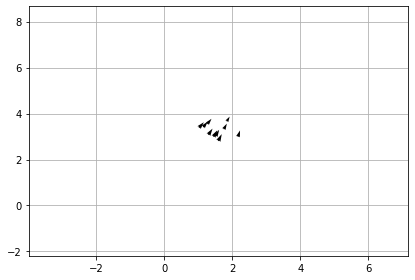

In [136]:
plot_dynamics(log)

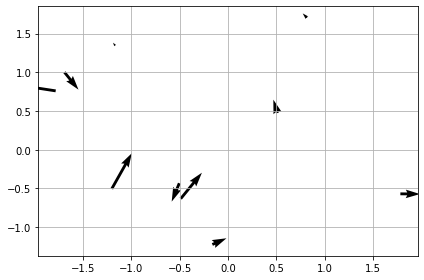

MovieWriter imagemagick unavailable; using Pillow instead.


In [137]:
# Plotting dynamics

# Animation function
def update_quiver(i, Q, ax, log):
    state = log[i]["state"]
    Q.set_offsets(state[:,:,0])
    Q.set_UVC(*(state[:,:,1].T))
    
    ax.set_xlim(state[:,0,0].min() - 5, state[:,0,0].max() + 5)
    ax.set_ylim(state[:,1,0].min() - 5, state[:,1,0].max() + 5)
    return Q,
    
# Create figure and add axes
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()
state = log[0]["state"]
Q = ax.quiver(*(state[:,:,0].T), *(state[:,:,1].T))

anim = FuncAnimation(fig, update_quiver, fargs=(Q, ax, log), frames=max_iters,
                               interval=10, blit=False)
fig.tight_layout()
plt.show()

anim.save('./gifs/nonlocal-velocity-update.gif', writer='imagemagick', fps=10)

Ну что ж, как мы выяснили, без учета локальности самоорганизации не возникает. В целом, оно и неудивительно. Значит, в следующих сериях надо бы и это учесть.

Я рад, что научился анимировать динамику. Это будет мне полезно.